In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
from scipy import signal
import meegkit
from meegkit import dss
from meegkit.utils import create_line_data, unfold

%matplotlib qt5

In [2]:
raw = mne.io.read_raw_fif('pre_filtered_data_raw.fif', preload=True)

Opening raw data file pre_filtered_data_raw.fif...
    Range : 25000 ... 1583999 =     50.000 ...  3167.998 secs
Ready.
Opening raw data file /home/ijekt/Documents/cs_cog_fat/pre_filtered_data_raw-1.fif...
    Range : 1584000 ... 2135999 =   3168.000 ...  4271.998 secs
Ready.
Reading 0 ... 2110999  =      0.000 ...  4221.998 secs...


# Notchfilter

In [3]:
# plot frequency band of raw data to explore powerline artifacts
raw.compute_psd(fmax=500).plot(picks="data", exclude="bads")
plt.show()

ValueError: Requested fmax (500 Hz) must not exceed ½ the sampling frequency of the data (250.0 Hz).

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

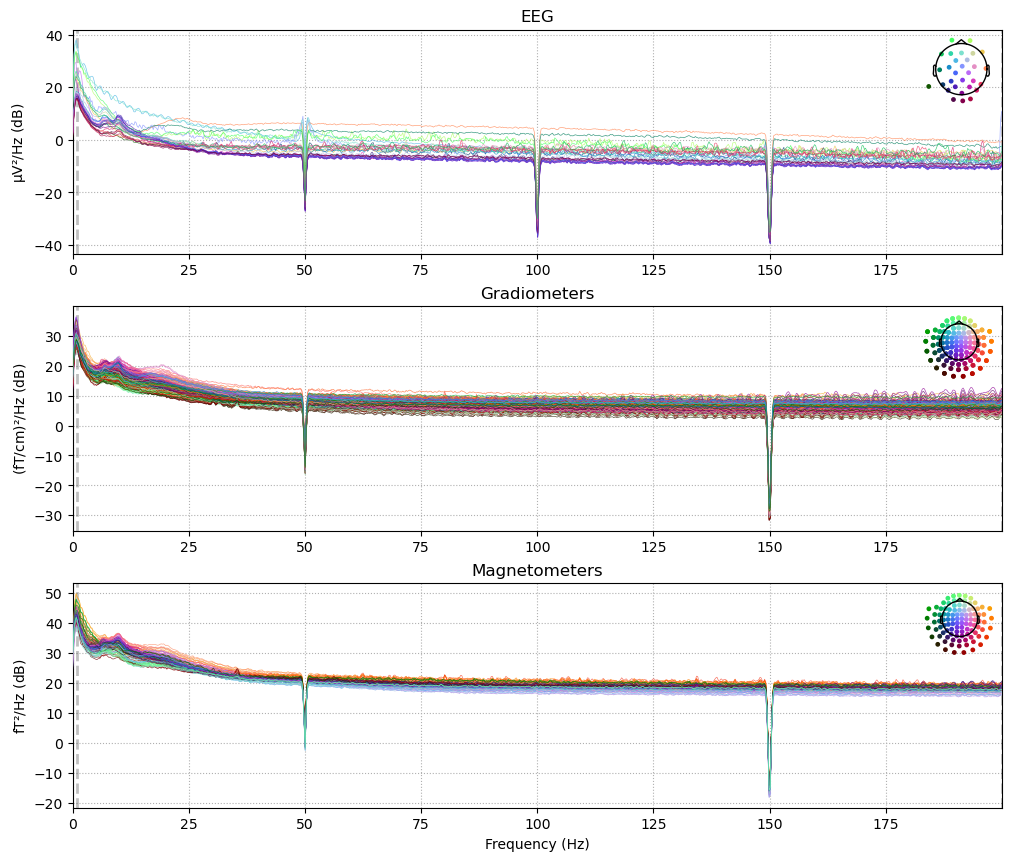

In [3]:
# Frequencies for notch filtering
eeg_freqs = [50, 100, 150]  # EEG artifacts
meg_freqs = [50, 150]       # MEG (mag and grad) artifacts

# Automatically calculate the filter length
filter_length = 'auto'
n_jobs = 1  # Number of parallel jobs

# Copy the raw data to keep the original data unchanged
raw_copy = raw.copy()

# Apply notch filter to EEG channels
eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False)
raw_copy.notch_filter(freqs=eeg_freqs, picks=eeg_picks, filter_length=filter_length, n_jobs=n_jobs, verbose=True)

# Apply notch filter to Magnetometer channels
mag_picks = mne.pick_types(raw.info, meg='mag')
raw_copy.notch_filter(freqs=meg_freqs, picks=mag_picks, filter_length=filter_length, n_jobs=n_jobs, verbose=True)

# Apply notch filter to Gradiometer channels
grad_picks = mne.pick_types(raw.info, meg='grad')
raw_copy.notch_filter(freqs=meg_freqs, picks=grad_picks, filter_length=filter_length, n_jobs=n_jobs, verbose=True)

# Plot the PSD of the raw data after notch filtering for a comprehensive view
raw_copy.plot_psd(fmax=200, picks='data', exclude='bads')

# Show the plots
#plt.show()

In [6]:
del raw_notch

In [4]:
# Save the filtered data
raw.save('pre_filtered_notch_data_raw.fif', overwrite=True)

Writing /home/ijekt/Documents/cs_cog_fat/pre_filtered_notch_data_raw.fif
Closing /home/ijekt/Documents/cs_cog_fat/pre_filtered_notch_data_raw.fif
Writing /home/ijekt/Documents/cs_cog_fat/pre_filtered_notch_data_raw-1.fif
Closing /home/ijekt/Documents/cs_cog_fat/pre_filtered_notch_data_raw-1.fif
[done]


# DSS

In [3]:
# Set the parameters
fline = 50  # Power line frequency in Hertz
sfreq = raw.info['sfreq']  # Sampling frequency in Hertz
print(sfreq)

500.0


In [4]:

# Extract time points
times = raw.times

# extract eeg, mag, grad channels
mag_channels = mne.pick_types(raw.info, meg='mag', eeg=False)
grad_channels = mne.pick_types(raw.info, meg='grad', eeg=False)
eeg_channels = mne.pick_types(raw.info, meg=False, eeg=True)

# extract eeg, mag, grad data
mag_data = raw.get_data(picks=mag_channels)
grad_data = raw.get_data(picks=grad_channels)
eeg_data = raw.get_data(picks=eeg_channels)

In [6]:
print(mag_data.shape)
print(grad_data.shape)
print(eeg_data.shape)

(102, 2111000)
(204, 2111000)
(30, 2111000)


In [6]:
#eeg_data_T = eeg_data.T

In [8]:
# Apply DSS to remove power line artifacts on eeg data
dss_eeg, iterations = meegkit.dss.dss_line_iter(eeg_data.T, fline, sfreq, nfft=400)
print(f"Removed {iterations} components")

Power of components removed by DSS: 0.30
Iteration 0 score: 1.120530448829135e-11
Power of components removed by DSS: 0.08
Iteration 1 score: 4.815800213677523e-12
Power of components removed by DSS: 0.05
Iteration 2 score: 1.0742877897813094e-12
Power of components removed by DSS: 0.02
Iteration 3 score: -1.6919944020119674e-13
Removed 3 components


In [9]:
# Apply DSS to remove power line artifacts on eeg data
dss_eeg, iterations = meegkit.dss.dss_line_iter(dss_eeg, fline, sfreq, nfft=400)
print(f"Removed {iterations} components")

Power of components removed by DSS: 0.00
Iteration 0 score: 5.686553939861002e-14
Power of components removed by DSS: 0.00
Iteration 1 score: 3.11549812912071e-14
Power of components removed by DSS: 0.00
Iteration 2 score: -3.82561742034805e-16
Removed 2 components


In [11]:
print(dss_eeg.shape)

(2111000, 30)


In [10]:
# Apply DSS to remove power line artifacts on meg data
dss_meg, iterations = meegkit.dss.dss_line_iter(mag_data.T, fline, sfreq, nfft=400)
print(f"Removed {iterations} components")

Power of components removed by DSS: 0.00
Iteration 0 score: 3.74813816821025e-30
Power of components removed by DSS: 0.00
Iteration 1 score: 2.5939230478747296e-30
Power of components removed by DSS: 0.01
Iteration 2 score: -1.2403151279950003e-30
Removed 2 components


In [ ]:
print(dss_meg.shape)

In [7]:
# Apply DSS to remove power line artifacts on grad data
dss_grad, iterations = meegkit.dss.dss_line_iter(grad_data.T, fline, sfreq, nfft=400)
print(f"Removed {iterations} components")

Power of components removed by DSS: 0.01
Iteration 0 score: 1.4168015668725303e-27
Power of components removed by DSS: 0.00
Iteration 1 score: 6.349443891193999e-28
Power of components removed by DSS: 0.01
Iteration 2 score: -9.531514963139507e-28
Removed 2 components


In [ ]:
print(dss_grad.shape)

In [11]:
# extract channel names
mag_names = [raw.ch_names[i] for i in mag_channels]
grad_names = [raw.ch_names[i] for i in grad_channels]
eeg_names = [raw.ch_names[i] for i in eeg_channels]

# reindex channel names and times
#df_grad = pd.DataFrame(data=dss_grad.T, index=grad_names, columns=times)
#df_mag = pd.DataFrame(data=dss_grad.T, index=mag_names, columns=times)
#df_eeg = pd.DataFrame(data=dss_eeg.T, index=eeg_names, columns=times)

In [12]:
# Create Info objects for each sensor type
info_mag = mne.create_info(ch_names=mag_names, sfreq=sfreq, ch_types='mag')
info_grad = mne.create_info(ch_names=grad_names, sfreq=sfreq, ch_types='grad')
info_eeg = mne.create_info(ch_names=eeg_names, sfreq=sfreq, ch_types='eeg')

# Create separate Raw objects
raw_mag = mne.io.RawArray(dss_meg.T, info_mag)
raw_grad = mne.io.RawArray(dss_grad.T, info_grad)
raw_eeg = mne.io.RawArray(dss_eeg.T, info_eeg)

Creating RawArray with float64 data, n_channels=102, n_times=2111000
    Range : 0 ... 2110999 =      0.000 ...  4221.998 secs
Ready.
Creating RawArray with float64 data, n_channels=204, n_times=2111000
    Range : 0 ... 2110999 =      0.000 ...  4221.998 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=2111000
    Range : 0 ... 2110999 =      0.000 ...  4221.998 secs
Ready.


In [13]:
# Extract data from each Raw object
data_mag, _ = raw_mag[:]
data_grad, _ = raw_grad[:]
data_eeg, _ = raw_eeg[:]

# Combine data arrays
combined_data = np.concatenate([data_mag, data_grad, data_eeg], axis=0)

# Combine channel names and types
combined_names = mag_names + grad_names + eeg_names
combined_types = ['mag'] * len(mag_names) + ['grad'] * len(grad_names) + ['eeg'] * len(eeg_names)

# Create a unified Info object
info_combined = mne.create_info(ch_names=combined_names, sfreq=sfreq, ch_types=combined_types)

# Create a new Raw object
raw_combined = mne.io.RawArray(combined_data, info_combined)


Creating RawArray with float64 data, n_channels=336, n_times=2111000
    Range : 0 ... 2110999 =      0.000 ...  4221.998 secs
Ready.


In [ ]:
raw_combined.save('dss_pl_raw.fif')

In [20]:
raw_combined = mne.io.read_raw_fif('dss_pl_raw.fif', preload=True)

Opening raw data file dss_pl_raw.fif...
Isotrak not found
    Range : 0 ... 1596499 =      0.000 ...  3192.998 secs
Ready.
Opening raw data file /home/ijekt/Documents/cs_cog_fat/dss_pl_raw-1.fif...
Isotrak not found
    Range : 1596500 ... 2110999 =   3193.000 ...  4221.998 secs
Ready.
Reading 0 ... 2110999  =      0.000 ...  4221.998 secs...


Effective window size : 4.096 (s)


/tmp/ipykernel_6407/335089163.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_combined.compute_psd(fmax=200).plot(picks="data", exclude="bads")
/tmp/ipykernel_6407/335089163.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_combined.compute_psd(fmax=200).plot(picks="data", exclude="bads")
/tmp/ipykernel_6407/335089163.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_combined.compute_psd(fmax=200).plot(picks="data", exclude="bads")


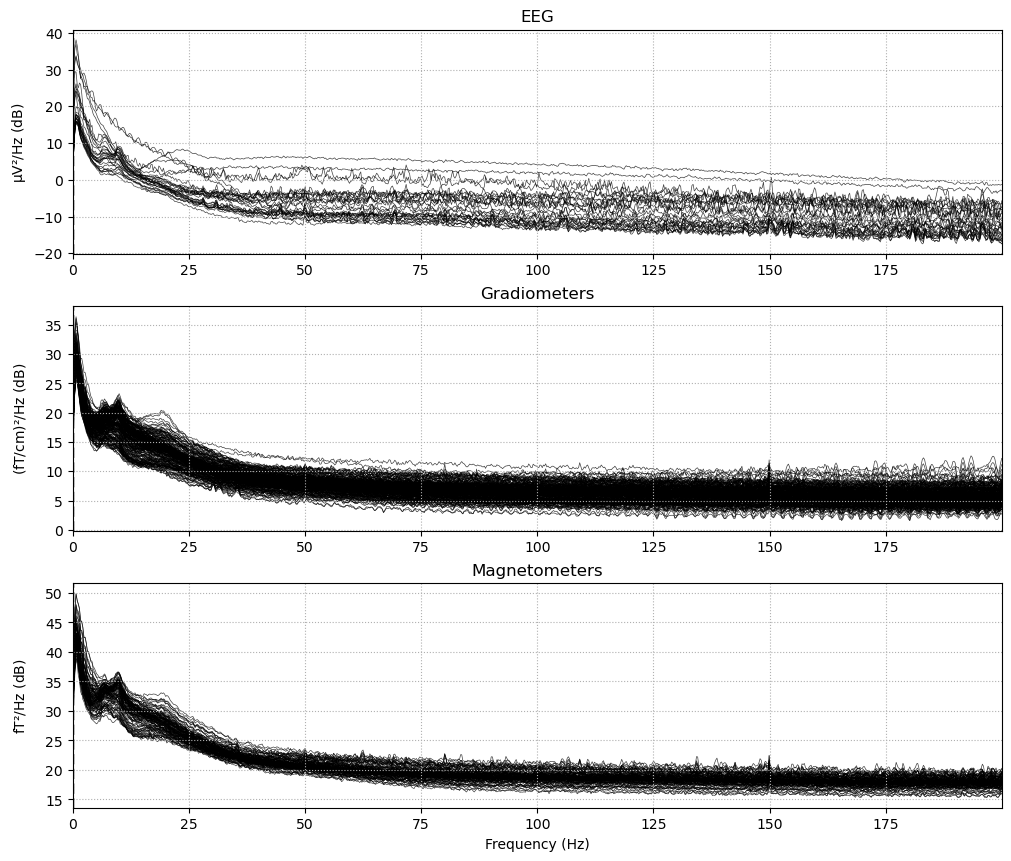

In [15]:
# plot frequency band of raw data to explore powerline artifacts
raw_combined.compute_psd(fmax=200).plot(picks="data", exclude="bads")

Using matplotlib as 2D backend.


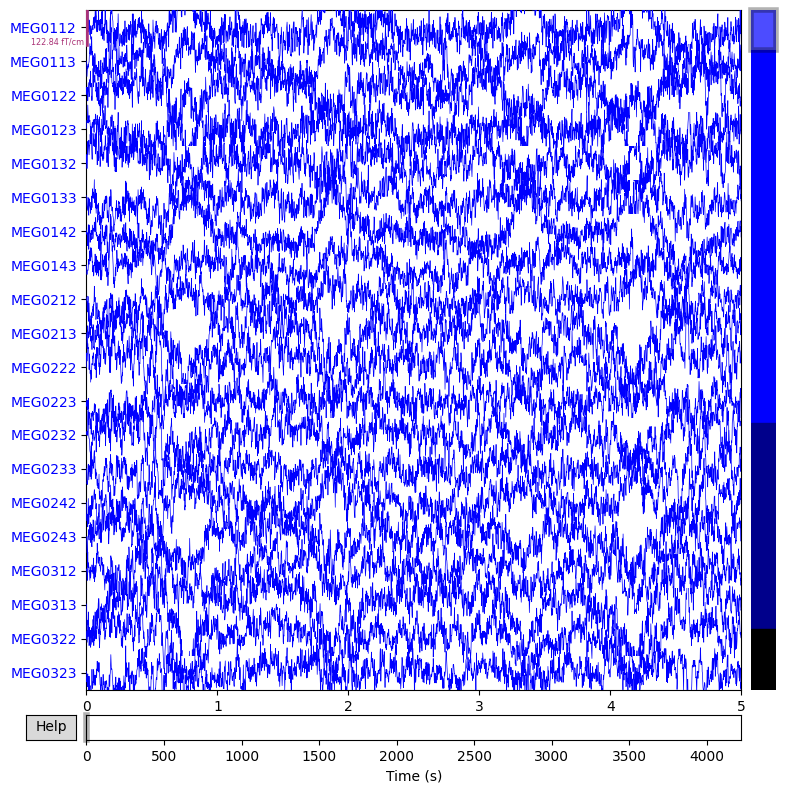

In [7]:
raw_combined.plot(duration=5, n_channels=20, scalings='auto')

# tighten eeg ar pl dss

In [8]:
raw = mne.io.read_raw_fif('pre_filtered_data_raw.fif', preload=True)

Opening raw data file pre_filtered_data_raw.fif...
    Range : 25000 ... 1583999 =     50.000 ...  3167.998 secs
Ready.
Opening raw data file /home/ijekt/Documents/cs_cog_fat/pre_filtered_data_raw-1.fif...
    Range : 1584000 ... 2135999 =   3168.000 ...  4271.998 secs
Ready.
Reading 0 ... 2110999  =      0.000 ...  4221.998 secs...


In [9]:
# Set the parameters
fline = 50  # Power line frequency in Hertz
sfreq = raw.info['sfreq']  # Sampling frequency in Hertz
print(sfreq)

500.0


In [10]:
eeg_channels = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data = raw.get_data(picks=eeg_channels)

In [11]:
print(eeg_data.shape)

(30, 2111000)


In [12]:
# Apply DSS to remove power line artifacts on eeg data
dss_eeg, iterations = meegkit.dss.dss_line_iter(eeg_data.T, fline, sfreq, nfft=400)
print(f"Removed {iterations} components")

Power of components removed by DSS: 0.30
Iteration 0 score: 1.120530448829135e-11
Power of components removed by DSS: 0.08
Iteration 1 score: 4.815800213677523e-12
Power of components removed by DSS: 0.05
Iteration 2 score: 1.0742877897813094e-12
Power of components removed by DSS: 0.02
Iteration 3 score: -1.6919944020119674e-13
Removed 3 components


In [13]:
print(dss_eeg.shape)

(2111000, 30)


In [16]:
# Apply DSS to remove power line artifacts on eeg data
dss_eeg, iterations = meegkit.dss.dss_line_iter(dss_eeg, fline, sfreq, nfft=400)
print(f"Removed {iterations} components")

Power of components removed by DSS: 0.00
Iteration 0 score: 5.686553939861002e-14
Power of components removed by DSS: 0.00
Iteration 1 score: 3.11549812912071e-14
Power of components removed by DSS: 0.00
Iteration 2 score: -3.82561742034805e-16
Removed 2 components


In [17]:
eeg_names = [raw.ch_names[i] for i in eeg_channels]

In [18]:
info_eeg = mne.create_info(ch_names=eeg_names, sfreq=sfreq, ch_types='eeg')
raw_eeg = mne.io.RawArray(dss_eeg.T, info_eeg)

Creating RawArray with float64 data, n_channels=30, n_times=2111000
    Range : 0 ... 2110999 =      0.000 ...  4221.998 secs
Ready.


Effective window size : 4.096 (s)


/tmp/ipykernel_8186/435111659.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_eeg.compute_psd(fmax=200).plot(picks="data", exclude="bads")


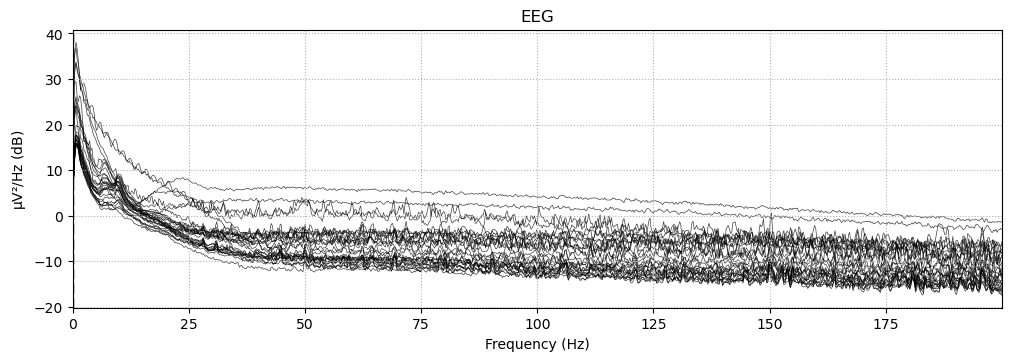

In [19]:
raw_eeg.compute_psd(fmax=200).plot(picks="data", exclude="bads")

In [ ]:
raw_eeg.save('dss_pl_eegtight_raw.fif')